# HAVOK non-linear system identification for simple pendulum

In [2]:
import numpy as np
from numpy import random
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

## Data gathering

(<matplotlib.legend.Legend at 0x25b59592880>,
 <matplotlib.legend.Legend at 0x25b595a71f0>)

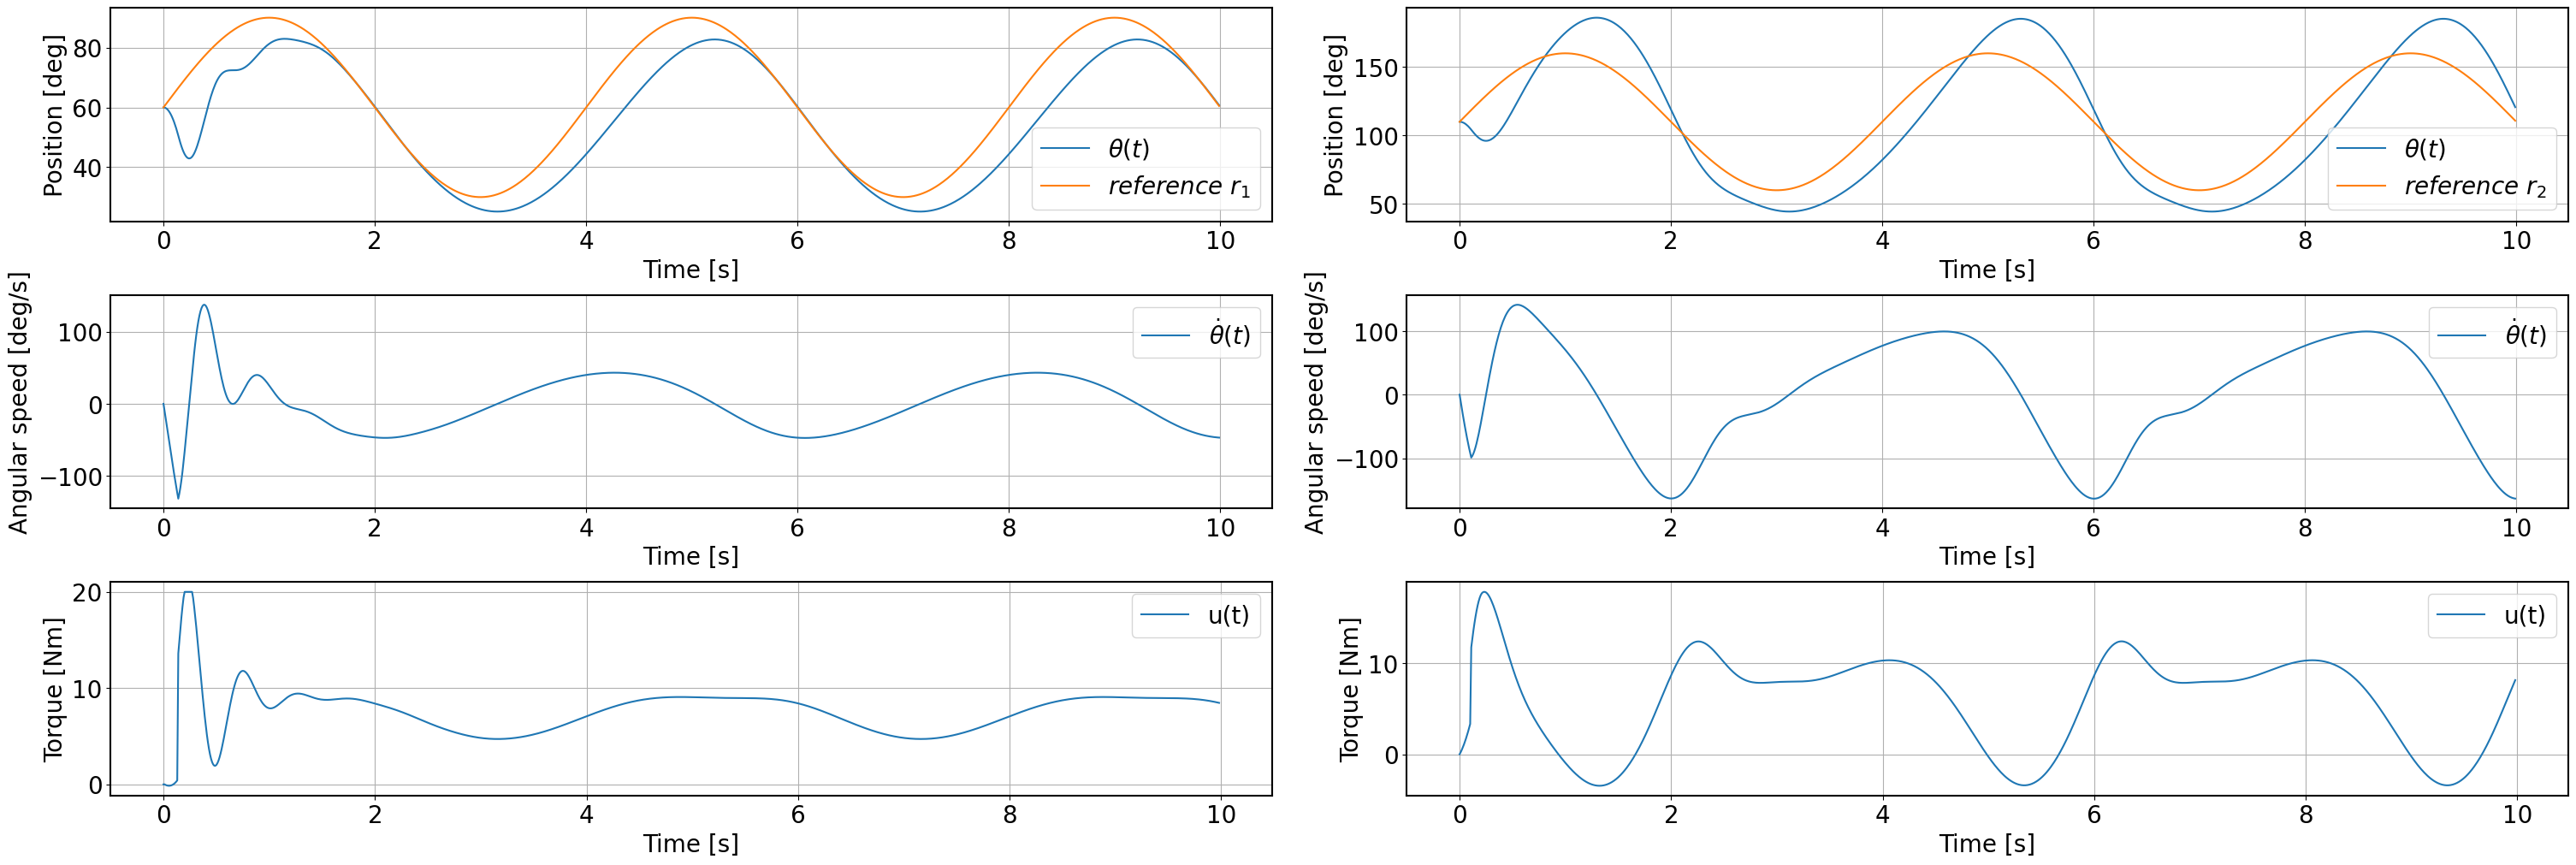

In [3]:
# Pendulum instance
dt = 1e-2
pend1 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(60),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(110),0]), dt=dt)

# Controller design
K, Ki, Kd, t_max = 10, 50, 0, 12

# Reference design
freq = .25
pend1.T_ref, pend2.T_ref = 1/freq/pend1.dt, 1/freq/pend2.dt
amplitude1, amplitude2 = 30, 50 # deg
pend1.ref = sineReference(pend1.N, pend1.dt, pend1.T_ref, amplitude1, 60)
# pend1.ref = sineReference(pend1.N, pend1.dt, [], [], offset=60, varying=True, freq_vector=[.4], amp_vector=[30])
# pend1.ref, precision = squareReference(pend1.N, pend1.T_ref, [deg2rad(70),deg2rad(30)], np.int(pend1.T_ref/10), 0)
pend2.ref = sineReference(pend1.N, pend1.dt, pend2.T_ref, amplitude2, 110)

# Simulation

for i in range(pend1.N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], 10, 1, 40, pend1.dt, 13, limit=20)[0]
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], 15, 0, 25, pend2.dt, 10, limit=20)[0]
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')
    
# Plots
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(3, 2, 
                       constrained_layout = True, figsize=(30,10))

ax[0,0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0,0].plot(pend1.T, rad2deg(np.array(pend1.ref)), label=r"$reference \ r_1$")
ax[0,1].plot(pend2.T, rad2deg(pend2.X[0,:]), label=r"$\theta (t)$")
ax[0,1].plot(pend1.T, rad2deg(np.array(pend2.ref)), label=r"$reference \ r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]'), ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Position [deg]')
ax[0,0].grid(), ax[0,1].grid()
ax[0,0].legend(), ax[0,1].legend()

ax[1,0].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,1].plot(pend1.T, rad2deg(pend2.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Angular speed [deg/s]'), ax[1,1].set_xlabel('Time [s]'), ax[1,1].set_ylabel('Angular speed [deg/s]')
ax[1,0].grid(), ax[1,1].grid()
ax[1,0].legend(), ax[1,1].legend()

ax[2,0].plot(pend1.T[:pend1.N-1], pend1.U, label='u(t)')
ax[2,1].plot(pend1.T[:pend1.N-1], pend2.U, label='u(t)')
ax[2,0].set_xlabel('Time [s]'), ax[2,0].set_ylabel('Torque [Nm]'), ax[2,1].set_xlabel('Time [s]'), ax[2,1].set_ylabel('Torque [Nm]')
ax[2,0].grid(), ax[2,1].grid()
ax[2,0].legend(), ax[2,1].legend()

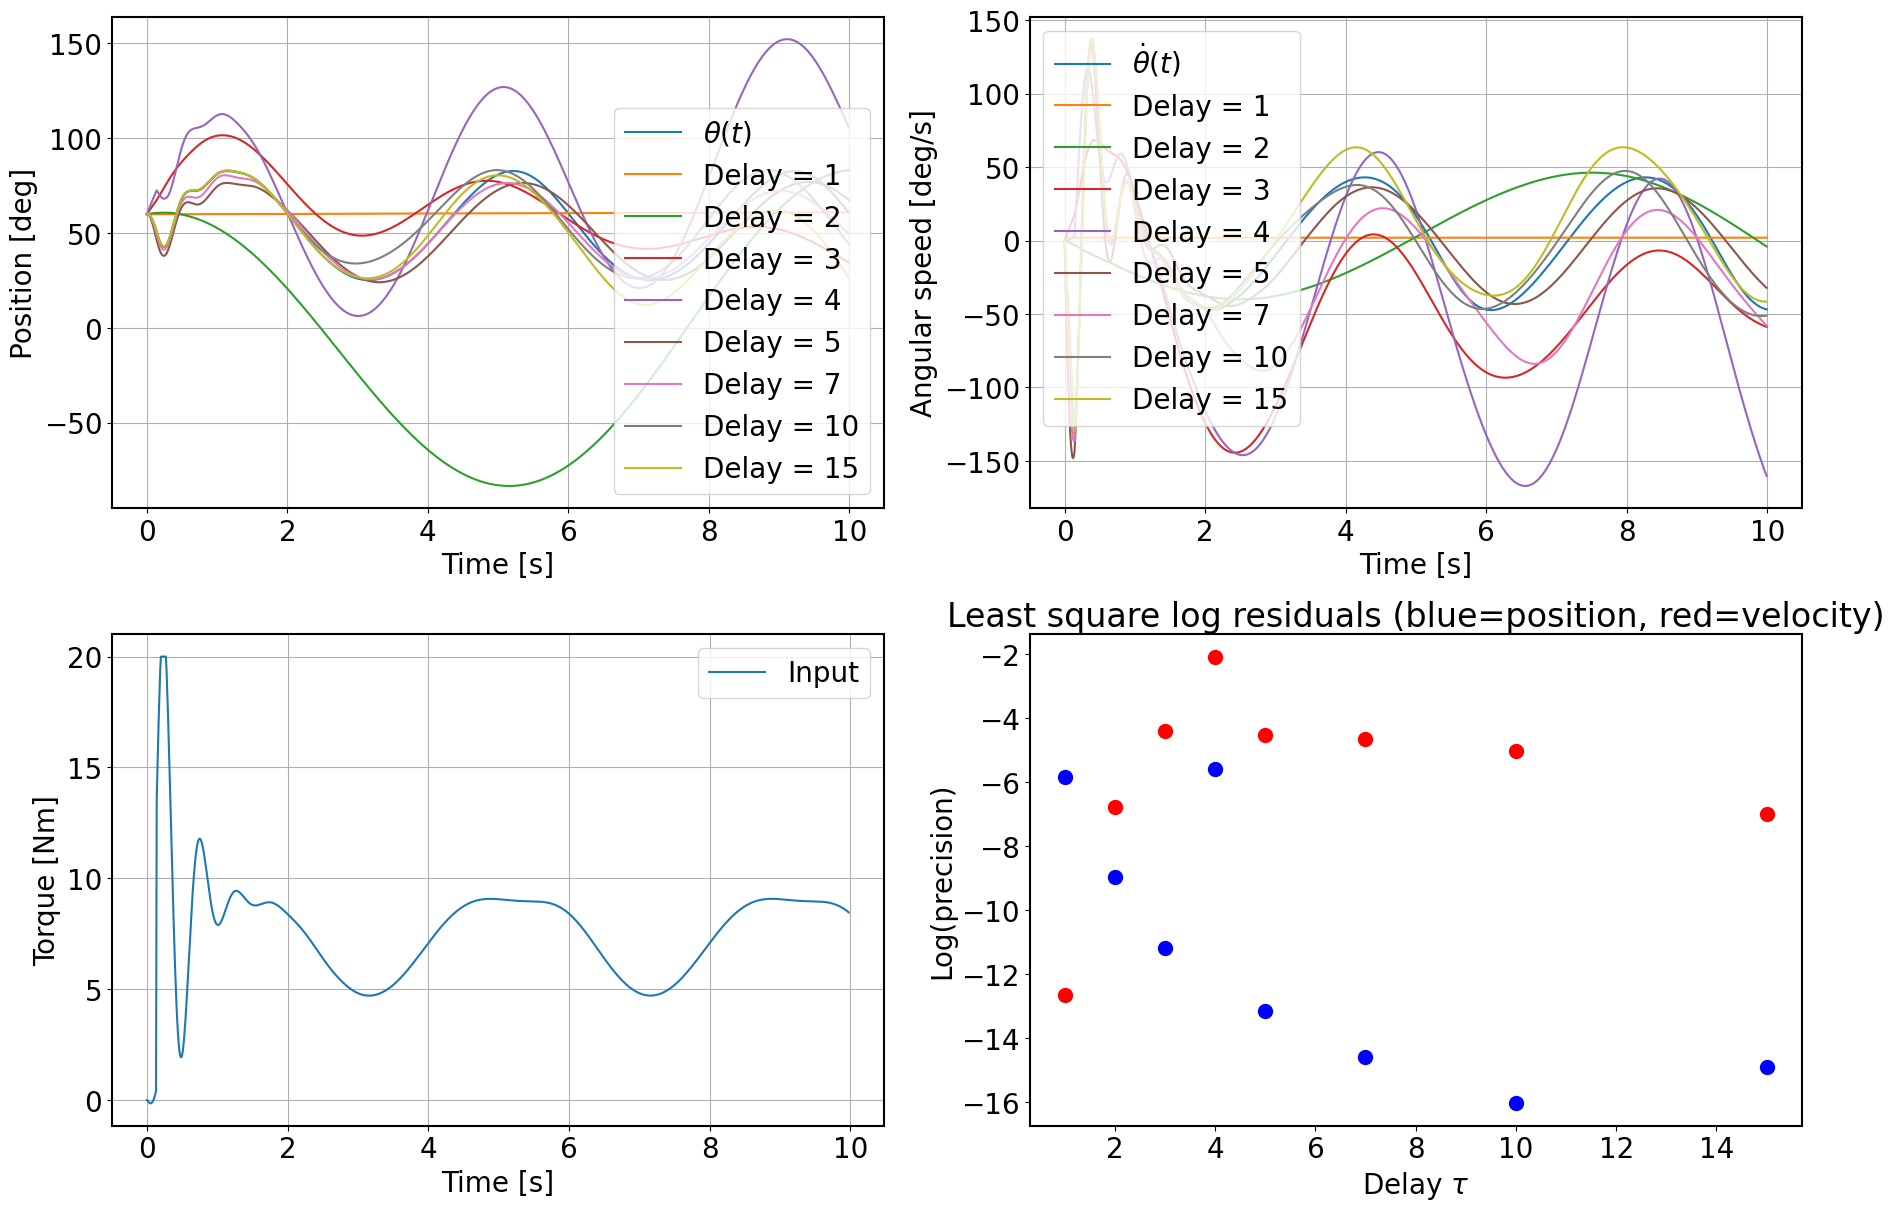

In [44]:
pend = pend1
horizon = 800
model1 = HAVOK(pend.X, pend1.U)
X0 = [deg2rad(60),0]

nb_delay = [1,2,3,4,5,7,10,15]
# nb_delay = [5]
nb_plots = len(nb_delay)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,12))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:len(pend.T)-1], pend.U, label='Input')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

for i in range(nb_plots):
    tau = nb_delay[i]
    model1.HANKEL(horizon)
    model1.SVD(tau)
    model1.LS()
    model1.Simulate(X0)
    
    
    ax[0,0].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[0,:]), label='Delay = '+str(tau))
    ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
    ax[0,0].grid()
    ax[0,0].legend()

    ax[0,1].plot(pend.T[:len(pend.T)], rad2deg(model1.X_traj[1,:]), label='Delay = '+str(tau))
    ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
    ax[0,1].grid()
    ax[0,1].legend()
    
    ax[1,1].plot(tau, np.log(model1.residuals[0]),'o', markersize=10, color='b')
    ax[1,1].plot(tau, np.log(model1.residuals[1]),'o', markersize=10, color='r')
    ax[1,1].set_xlabel(r'Delay $\tau$'), ax[1,1].set_ylabel('Log(precision)')
    ax[1,1].grid(), ax[1,1].set_title('Least square log residuals (blue=position, red=velocity)')

## LQR tracking
### LQR rollout

In [30]:
model1.tau = 5
model1.HANKEL(horizon)
model1.SVD(model1.tau)
model1.LS()

lqr_tracking = pbd.LQR(model1.A, model1.B, nb_dim=model1.tau, dt=pend.dt, horizon=model1.N)

reference = np.zeros([model1.N,model1.nb_S])
reference[:,0] = pend.ref

lqr_tracking.z = (pinv(model1.C)@reference.T).T

# Trajectory timing (1 via-point = 1 time-step, should be as long as the horizon)
seq_tracking = 1*[0]

for i in range(1,model1.N):
    seq_tracking += (1)*[i]
    
lqr_tracking.seq_xi = seq_tracking

# Control precision 
u_std = 2. # means 1e-3
lqr_tracking.gmm_u = u_std

# Tracking precision
x_std = 1e6 # Importance of tracking the position
Q_tracking = np.empty(shape=[model1.N,model1.tau,model1.tau])

for i in range(model1.N):
    Q_tracking[i,:,:] = model1.C.T@np.diag([x_std,0])@model1.C # Put zero velocity precision
    
lqr_tracking.Q = Q_tracking

lqr_tracking.ricatti()

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(880.5768176960553, 0.5, 'Delay $\\tau$'))

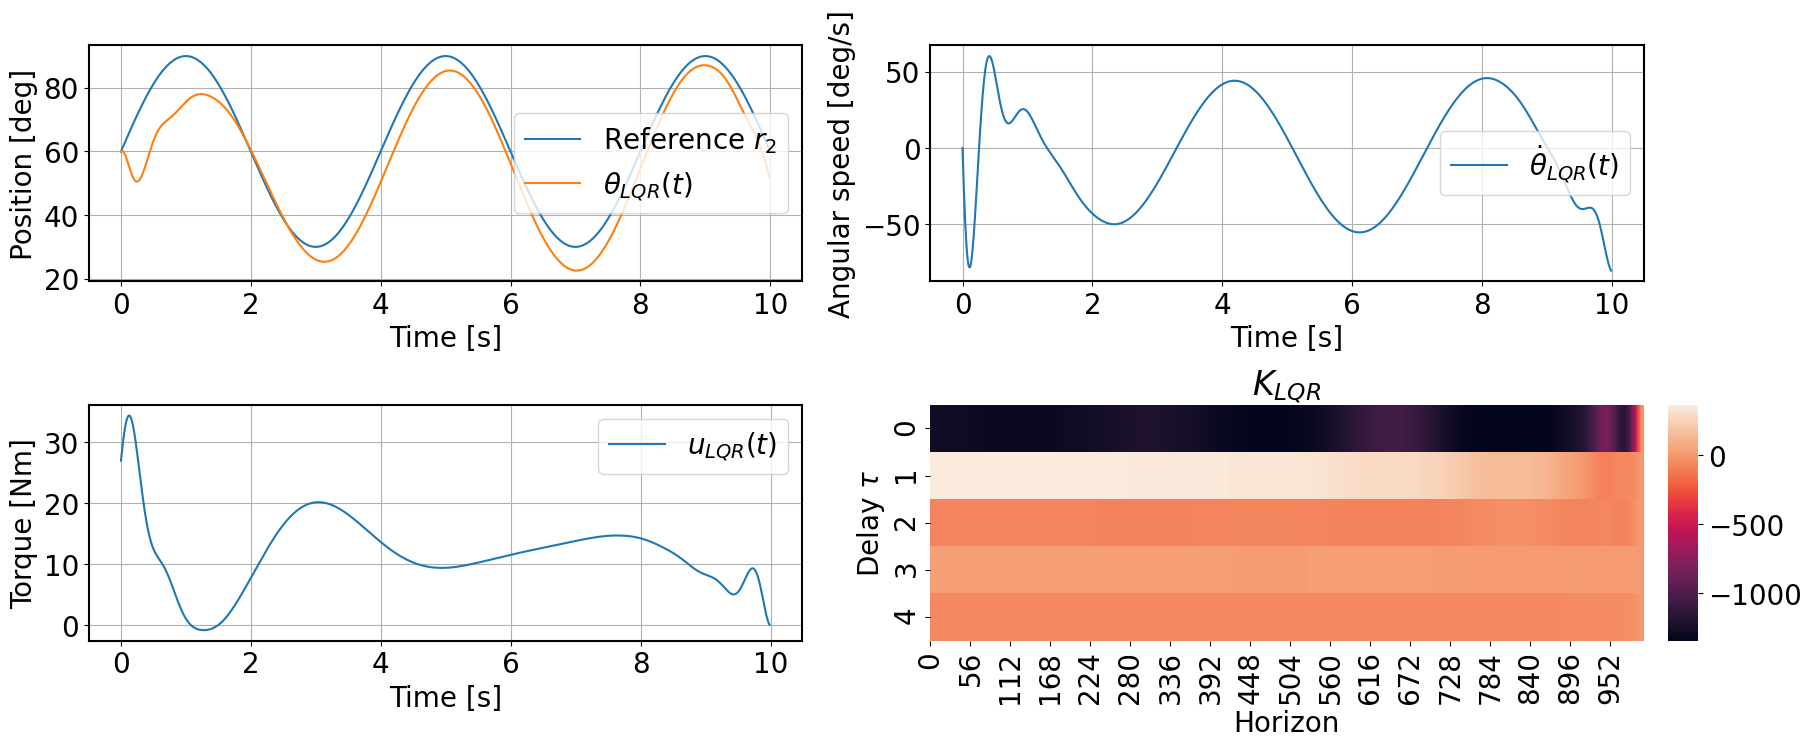

In [31]:
# Simulate the closed-loop system
N = np.eye(model1.tau) - pinv(model1.C)@model1.C # Nullspace projection operator
Y0 = np.zeros((1,model1.tau))
Y0[0,:] = pinv(model1.C)@pend.X0 + N@(model1.Y[:,0] - pinv(model1.C)@pend.X0)
ys, us = lqr_tracking.make_rollout(Y0)
ys_mean = np.mean(ys, axis=0)
xs = model1.C@ys_mean.T # Map back to original space
xs = xs.T

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].plot(pend.T, rad2deg(xs[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(xs[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], us[0,:,0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(lqr_tracking._K)[:,0,:].T)
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Delay $\tau$')

### LQR open-loop control

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(898.6810906658442, 0.5, 'Delay $\\tau$'))

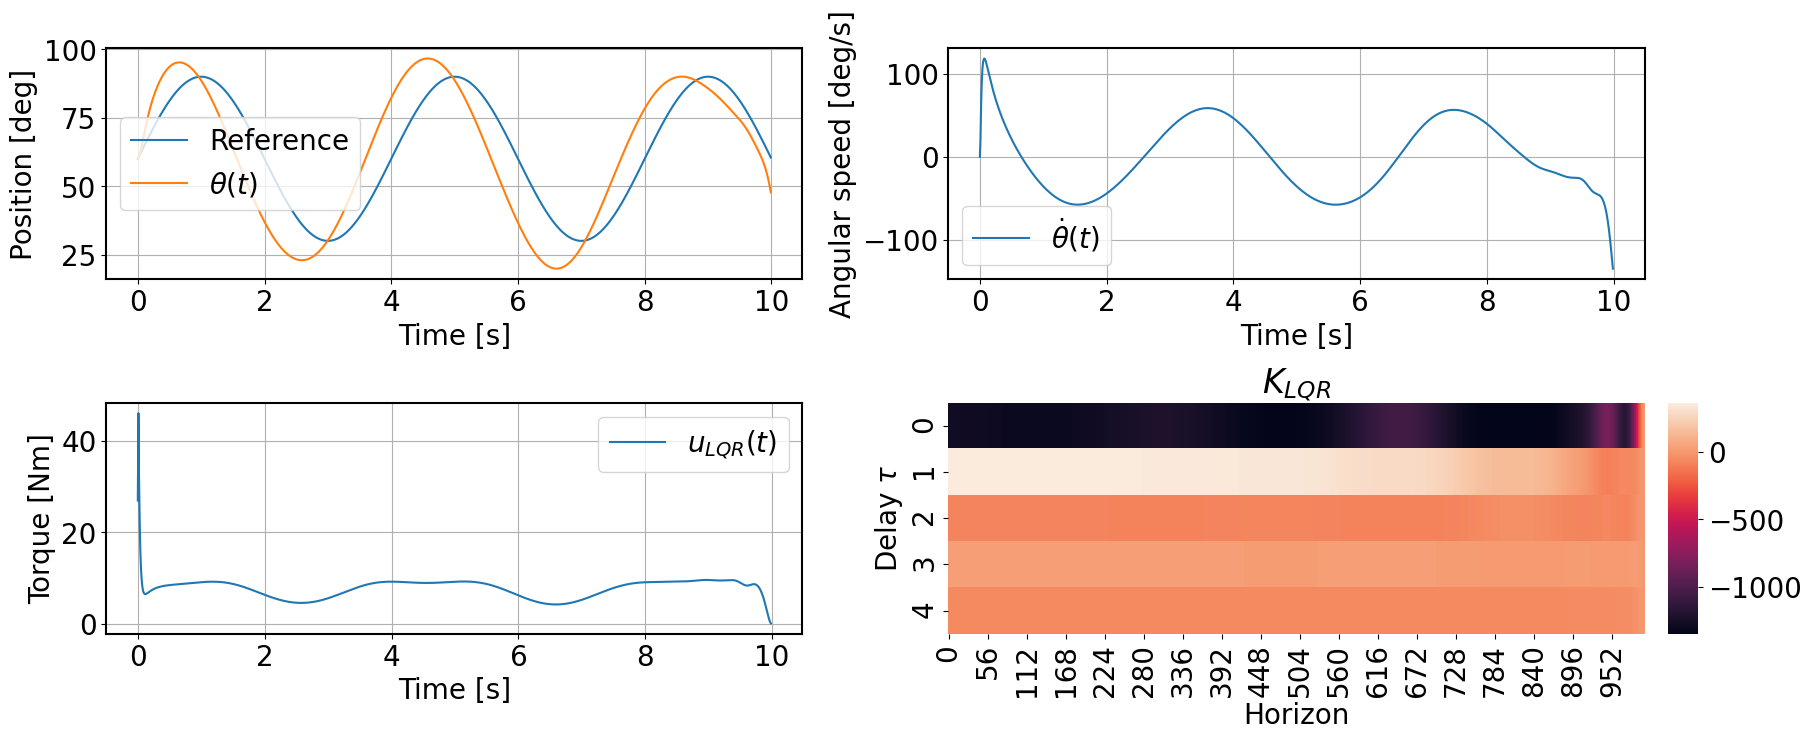

In [39]:
X0 = np.array([deg2rad(60),0])
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(lqr_tracking.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = lqr_tracking.get_command(Yc[:,i],i)
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, 
                       constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label='Reference')
ax[0,0].plot(pend.T, rad2deg(Xc[0,:]), label=r"$\theta (t)$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[1,:]), label=r"$\dot{\theta} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:model1.N-1], Uc, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(Ky.T))
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Delay $\tau$')